In [1]:
from matplotlib import cm, colors
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import linregress

# band filter
def raster_filter_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1) - gaussian_filter(raster.values,g2)
    return raster

In [3]:
import xarray as xr
import numpy as np
from vtk import vtkStructuredGridReader
from vtk.util import numpy_support as VN

def vtk2da(filename):
    reader = vtkStructuredGridReader()
    reader.SetFileName(filename)
    reader.ReadAllScalarsOn()
    reader.Update()

    data = reader.GetOutput()
    dim = data.GetDimensions()
    bnd = data.GetBounds()
    #print (dim, bnd)
    values = VN.vtk_to_numpy(data.GetPointData().GetArray('trace'))
    values = values.reshape(dim,order='F')

    da = xr.DataArray(values.transpose([2,1,0]),
                coords=[np.linspace(bnd[4],bnd[5],dim[2]),
                        np.linspace(bnd[2],bnd[3],dim[1]),
                        np.linspace(bnd[0],bnd[1],dim[0])],
                dims=['z','y','x'])
    return da

### Load dataset

In [4]:
da = vtk2da('Seismic_data_subset.vtk')
# TODO: fix Z axis values order
da.z.values = da.z.values[::-1]
da

<xarray.DataArray (z: 262, y: 401, x: 551)>
array([[[ -229.,   501., ...,  -708., -1609.],
        [  -58.,   460., ...,  -708.,   426.],
        ...,
        [ -937.,  -243., ...,  2163.,  1340.],
        [-1146., -1095., ...,  1735.,   582.]],

       [[ 1079.,  1890., ..., -2853., -3890.],
        [ 1495.,  2306., ..., -3650., -5140.],
        ...,
        [ -903.,  -196., ...,  -174.,  -345.],
        [ -909.,  -492., ...,  -462.,  -879.]],

       ...,

       [[-2098., -3480., ..., -1506., -1088.],
        [-2425., -2233., ..., -1277., -1278.],
        ...,
        [-2329., -3184., ...,  4466.,  3347.],
        [ -710.,  -596., ...,   522.,  1794.]],

       [[ -699., -1722., ..., -1023.,   -31.],
        [-1099., -2488., ..., -1643.,  -685.],
        ...,
        [-3225., -3401., ..., -2071., -1243.],
        [-2199., -1903., ..., -2507., -2429.]]], dtype=float32)
Coordinates:
  * z        (z) float64 -800.0 -804.0 -808.0 ... -1.84e+03 -1.844e+03
  * y        (y) float64 6.074e+

In [5]:
np.diff(da.x)[0],np.diff(da.y)[0],np.diff(da.z)[0]

(25.498068181797862, 25.950000000186265, -4.0)

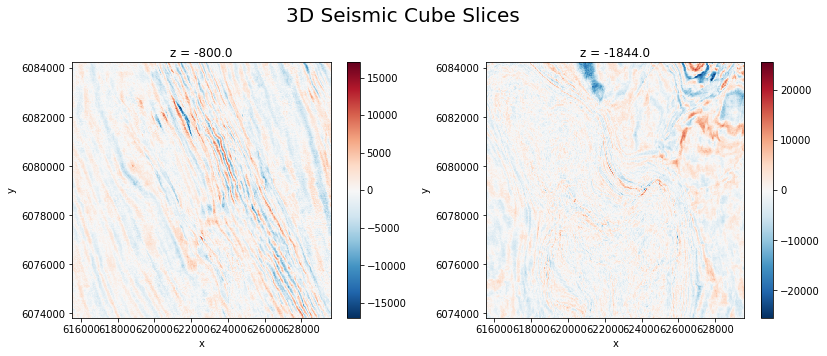

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

da.sel(z=da.z[0]).plot(ax=ax1)

da.sel(z=da.z[-1]).plot(ax=ax2)

fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.suptitle('3D Seismic Cube Slices',fontsize=20)
plt.show()

### Calculate spatial spectrum components

In [7]:
gammas = np.arange(1,51)
#gammas = np.array([1,10,20,30,40])

powers = []
for g in gammas:
    power1 = raster_filter_range(da.sel(z=da.z[0]), g-.5, g+.5).std()
    power2 = raster_filter_range(da.sel(z=da.z[-1]), g-.5, g+.5).std()
    powers.append(power1/power2)

da_power0 = xr.DataArray(np.array(powers),
                          coords=[25*gammas],
                          dims=['r'])

In [8]:
gammas = np.arange(1,51)
#gammas = np.array([1,10,20,30,40])
zs = da.z.values
#zs = da.z.values[::10]

powers = []
for z in zs:
    print (z,". ", end = '')
    for g in gammas:
        power = raster_filter_range(da.sel(z=z), g-.5, g+.5).std()
        powers.append(power)
da_power = xr.DataArray(np.array(powers).reshape([len(zs),len(gammas)]),
                          coords=[zs,25*gammas],
                          dims=['z','r'])

-800.0 . -804.0 . -808.0 . -812.0 . -816.0 . -820.0 . -824.0 . -828.0 . -832.0 . -836.0 . -840.0 . -844.0 . -848.0 . -852.0 . -856.0 . -860.0 . -864.0 . -868.0 . -872.0 . -876.0 . -880.0 . -884.0 . -888.0 . -892.0 . -896.0 . -900.0 . -904.0 . -908.0 . -912.0 . -916.0 . -920.0 . -924.0 . -928.0 . -932.0 . -936.0 . -940.0 . -944.0 . -948.0 . -952.0 . -956.0 . -960.0 . -964.0 . -968.0 . -972.0 . -976.0 . -980.0 . -984.0 . -988.0 . -992.0 . -996.0 . -1000.0 . -1004.0 . -1008.0 . -1012.0 . -1016.0 . -1020.0 . -1024.0 . -1028.0 . -1032.0 . -1036.0 . -1040.0 . -1044.0 . -1048.0 . -1052.0 . -1056.0 . -1060.0 . -1064.0 . -1068.0 . -1072.0 . -1076.0 . -1080.0 . -1084.0 . -1088.0 . -1092.0 . -1096.0 . -1100.0 . -1104.0 . -1108.0 . -1112.0 . -1116.0 . -1120.0 . -1124.0 . -1128.0 . -1132.0 . -1136.0 . -1140.0 . -1144.0 . -1148.0 . -1152.0 . -1156.0 . -1160.0 . -1164.0 . -1168.0 . -1172.0 . -1176.0 . -1180.0 . -1184.0 . -1188.0 . -1192.0 . -1196.0 . -1200.0 . -1204.0 . -1208.0 . -1212.0 . -1216.0 . 

### Plot spatial spectrum components

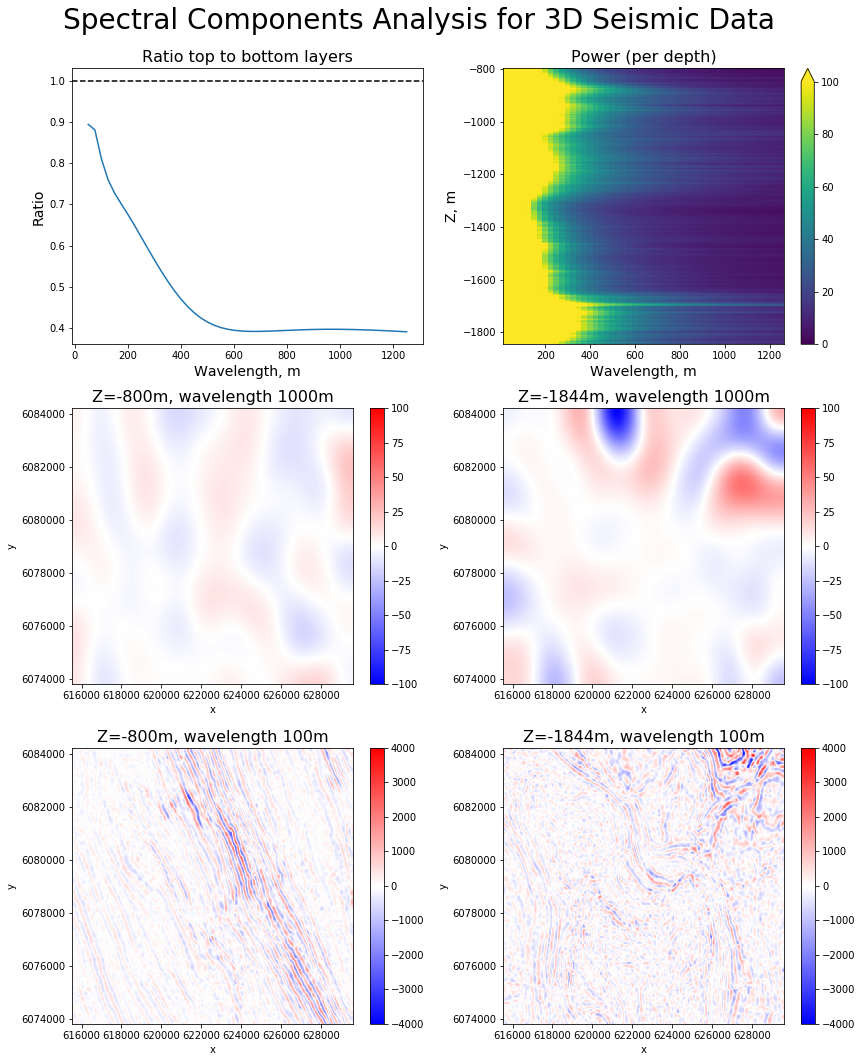

In [9]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(12.5,15))

da_power0[1:].plot(ax=ax1)
ax1.set_title('Ratio top to bottom layers',fontsize=16)
ax1.set_xlabel('Wavelength, m',fontsize=14)
ax1.set_ylabel('Ratio',fontsize=14)
ax1.axhline(y=1, xmin=0, xmax=1, color = 'black', ls='--', alpha=1)

da_power.plot(ax=ax2,vmin=0,vmax=100)
ax2.set_title('Power (per depth)',fontsize=16)
ax2.set_xlabel('Wavelength, m',fontsize=14)
ax2.set_ylabel('Z, m',fontsize=14)

data1 = raster_filter_range(da.sel(z=da.z[0]),40,41)
data1.plot(ax=ax3,cmap='bwr',vmin=-100,vmax=100)
ax3.set_title('Z=-800m, wavelength 1000m',fontsize=16)
data2 = raster_filter_range(da.sel(z=da.z[-1]),40,41)
data2.plot(ax=ax4,cmap='bwr',vmin=-100,vmax=100)
ax4.set_title('Z=-1844m, wavelength 1000m',fontsize=16)

data1 = raster_filter_range(da.sel(z=da.z[0]),2,3)
data1.plot(ax=ax5,cmap='bwr',vmin=-4000,vmax=4000)
ax5.set_title('Z=-800m, wavelength 100m',fontsize=16)

data2 = raster_filter_range(da.sel(z=da.z[-1]),2,3)
data2.plot(ax=ax6,cmap='bwr',vmin=-4000,vmax=4000)
ax6.set_title('Z=-1844m, wavelength 100m',fontsize=16)

plt.suptitle('Spectral Components Analysis for 3D Seismic Data',fontsize=28)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.95])
plt.savefig('Spectral Components Analysis for 3D Seismic Data.jpg', dpi=150)
plt.show()